This experiment shows that even after the pixels in hand-written digits images are scrambled, they can still be clustered effectively by t-SNE. It means that t-SNE doesn't take information about the translation/rotaional/illumination invariance in an image for clustering, which is very different from typical image recognition tasks. t-SNE itself doesn't have much to do with images, either.

In [1]:
import itertools

import pandas as pd

# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [2]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

### Load data

In [3]:
digits = load_digits()
digits.data.shape

(1797, 64)

### After scramble

In [4]:
digits.images.shape

(1797, 8, 8)

In [5]:
dim = digits.images.shape[1]
dim

8

In [6]:
# Generated scrambled indexes
idxes = np.random.permutation(dim ** 2).reshape((dim, dim))
idxes

array([[ 3,  4, 44, 35, 22, 41, 58, 52],
       [24, 12,  7, 13,  8, 17, 50,  5],
       [33, 31,  2,  6, 57, 23, 53, 40],
       [26, 42, 28, 16, 18,  1, 29, 25],
       [14, 59, 54, 60, 37, 34, 56, 51],
       [30, 62, 10, 11, 61, 47, 48, 55],
       [45, 15, 46, 63, 39, 49, 43, 38],
       [32, 20,  0, 21,  9, 19, 27, 36]])

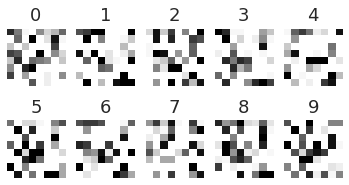

In [7]:
# Show scrambled images
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
# plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...].ravel()[idxes])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [8]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [9]:
df_X = pd.DataFrame(X)

In [10]:
df_X.shape

(1797, 64)

In [11]:
df_X.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


In [12]:
df_X_scrambled = df_X[df_X.columns[idxes.ravel()]]
df_X_scrambled.head(1)

,3,4,44,35,22,41,58,52,24,12,...,43,38,32,20,0,21,9,19,27,36
0,13.0,9.0,1.0,0.0,8.0,4.0,6.0,10.0,0.0,10.0,...,0.0,8.0,0.0,0.0,0.0,11.0,0.0,2.0,0.0,0.0


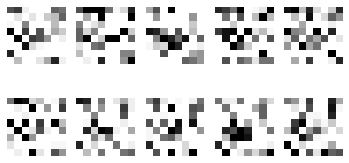

In [13]:
# Make sure columns in df_X_scrambled is indeed scrambled
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
# plt.gray()
sampled = df_X_scrambled.sample(nrows * ncols).reset_index(drop=True)
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(sampled.iloc[i].reshape(dim, dim))
    plt.xticks([]); 
    plt.yticks([])

In [23]:
df = df_X_scrambled.copy()

In [24]:
df['y'] = y

In [25]:
df = df[df.y == 0]

In [26]:
# reorder pixel based on 0 images only, which may emphasize the right order
df.drop('y', axis=1, inplace=True)

In [27]:
df.rename(columns=dict(zip(df.columns.values, range(df.columns.shape[0]))), inplace=True)

In [28]:
df.shape

(178, 64)

In [29]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,13.0,9.0,1.0,0.0,8.0,4.0,6.0,10.0,0.0,10.0,...,0.0,8.0,0.0,0.0,0.0,11.0,0.0,2.0,0.0,0.0


In [30]:
df.rename(columns=dict(zip(df.columns.values, range(df.columns.shape[0]))), inplace=True)

In [31]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,13.0,9.0,1.0,0.0,8.0,4.0,6.0,10.0,0.0,10.0,...,0.0,8.0,0.0,0.0,0.0,11.0,0.0,2.0,0.0,0.0


In [32]:
# just use the result dataframe as a placeholder
corr = df.corr()
corr.iloc[:,:] = -1

In [33]:
corr.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [34]:
# df.loc[:, 7].describe()

In [35]:
# 25491 is pretty big a number!
assert list(itertools.combinations_with_replacement([1, 2, 3], 2)) == [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
assert np.correlate(df.loc[:, 9], df.loc[:, 37]) == np.correlate(df.loc[:, 37], df.loc[:, 9])

In [36]:
for col_a, col_b in itertools.combinations_with_replacement(df.columns.tolist(), 2):
    corr.loc[col_a, col_b] = np.correlate(df[col_a], df[col_b])
    if col_a != col_b:
        corr.loc[col_b, col_a] = np.correlate(df[col_b], df[col_a])

In [37]:
corr.head(2)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,31419.0,26499.0,3400.0,2120.0,8237.0,8281.0,9848.0,24173.0,0.0,26851.0,...,3849.0,16808.0,0.0,4999.0,0.0,28669.0,2119.0,12184.0,4661.0,89.0
1,26499.0,24787.0,3350.0,1813.0,7683.0,7134.0,8319.0,20963.0,0.0,22177.0,...,3430.0,14263.0,0.0,3451.0,0.0,24174.0,1839.0,10277.0,3916.0,97.0


In [38]:
dd = {}
for i in range(df.columns.shape[0]):
#     argsort_idxes = corr[i].argsort().ix[::-1].values
    argsort_idxes = corr[i].argsort().values
    dd[i] = argsort_idxes[argsort_idxes != i].tolist()

In [39]:
# dd contains the most correlated 4 pixels for each pixel, then try to construct an image based on such information
# dd

In [40]:
# used_cols = []
# pixels = dd.keys()
# seed = np.ones((3, 3))
# seed = -seed
# # neighbour_idxes = [[0, 1], [1, 0], [1, 2], [2, 1]]
# x = y = 1
# neighbour_idxes = [(x - 1, y), (x, y - 1), (x, x + 1), (y + 1, y)]
# while pixels:
#     p = pixels.pop(0)
#     counter = 0
#     seed[1, 1] = p
#     for i in dd[p]:  
#         if i in used_cols:
#             continue

#         nidx = neighbour_idxes[counter]
#         seed[nidx[0], nidx[1]] = i
        
#         used_cols.append(i)
#         counter += 1
#         if counter == 4:
#             break
# #         seed[0, 1] = i
# #         seed[1, 0] = i
# #         seed[1, 2] = i
# #         seed[2, 1] = i
#     break

In [41]:
def fill(center, image, dd, pixel, used_cols):
    if len(used_cols) == len(dd.keys()):
        return image
    x, y = center
    neighbour_idxes = [(x - 1, y), (x, y - 1), (x, x + 1), (y + 1, y)]
    counter = 0
    if image[x, y] == -1: # init
        image[x, y] = pixel
    for i in dd[pixel]:  
        if i in used_cols:
            continue

        nidx = neighbour_idxes[counter]
        if image[nidx[0], nidx[1]] == -1:
            image[nidx[0], nidx[1]] = i
            used_cols.append(i)
        counter += 1
        if counter == 4:
            break

    for k, neighbour in enumerate(neighbour_idxes):
        # clockwise
        if k == 0:
            pw = [(0, 0), (1, 0)]
            center = center
        elif k == 1:
            pw = [(1, 0), (0, 0)]
            center = center
        elif k == 2:
            pw = [(0, 0), (0, 1)]
            center = (center[0] + 1, center[1])
        elif k == 3:
            pw = [(0, 1), (0, 0)]
            center = (center[0], center[1] + 1)
        else:
            raise
        
        padded_img = np.pad(image, pad_width=pw, mode='constant', constant_values=-1) 
        pixel = image[center[0], center[1]]
        return fill(center, padded_img, dd, pixel, used_cols)

In [42]:
image = np.ones((3, 3))
image = -image

In [43]:
used_cols = []
pixel = dd.keys()[0]
img = fill((1, 1), image, dd, pixel, used_cols)
img

array([[ -1.,  -1.,  28.,  24.,   1.,   7.,  55.,   6.,  13.,   2.,  15.,
         32.,  29.,  33.,  47.,  63.,  42.,  39.,  51.,  20.,  35.,   0.,
         12.,  38.,  -1.],
       [ -1.,  -1.,  25.,  14.,  48.,  30.,  16.,   4.,  57.,   5.,  53.,
          3.,  50.,  19.,  45.,  44.,  41.,  58.,  10.,  37.,  34.,  52.,
         21.,   0.,  56.],
       [ -1.,  -1.,  -1.,  -1.,  22.,  59.,   9.,  11.,  31.,  61.,  18.,
         60.,  62.,  54.,  26.,  49.,  46.,  43.,  27.,   8.,  40.,  36.,
         17.,  23.,  -1.]])

In [44]:
descrambled_idxes = img.astype(int)

In [45]:
img.shape

(3, 25)

In [46]:
pd.Series(y).value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

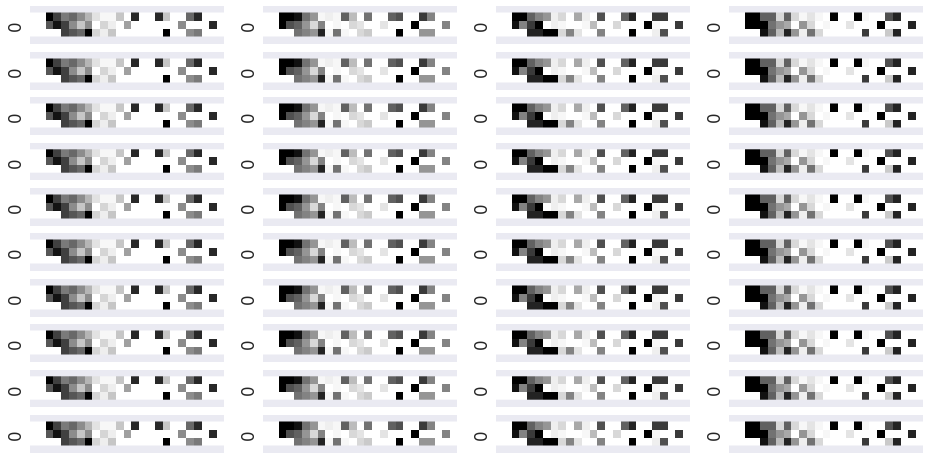

In [47]:
# Make sure columns in df_X_scrambled is indeed scrambled
n_per_digit = 4
nrows, ncols = n_per_digit * 10 / 4, 4
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(16, 8))
axes = axes.ravel()
for i in range(10):
    for j in range(n_per_digit):
        ax = axes[i * n_per_digit + j]
        ax.matshow(df.iloc[j].values[descrambled_idxes])
        ax.set_ylabel('{0}'.format(y[j]))
        ax.grid(False)
        plt.xticks([])
        plt.yticks([])

In [48]:
df_all = df_X_scrambled.copy()

In [49]:
df_all.rename(columns=dict(zip(df.columns.values, range(df.columns.shape[0]))), inplace=True)

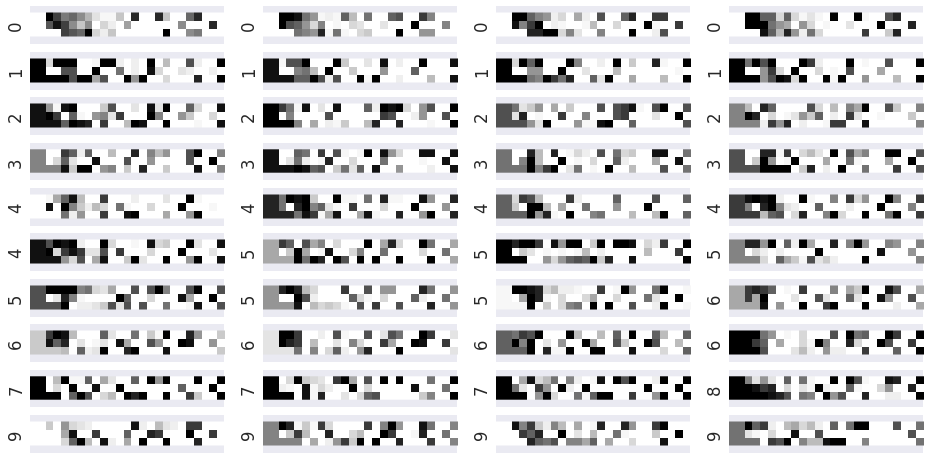

In [50]:
# Make sure columns in df_X_scrambled is indeed scrambled
n_per_digit = 4
nrows, ncols = n_per_digit * 10 / 4, 4
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(16, 8))
axes = axes.ravel()
for i in range(10):
    for j in range(n_per_digit):
        ax = axes[i * n_per_digit + j]
        ax.matshow(df_all.iloc[j + 180 * i].values[descrambled_idxes])
        ax.set_ylabel('{0}'.format(y[j + 180 * i]))
        ax.grid(False)
        plt.xticks([])
        plt.yticks([])

In [52]:
descrambled_idxes.ravel()[:64].reshape(8, 8)

array([[-1, -1, 28, 24,  1,  7, 55,  6],
       [13,  2, 15, 32, 29, 33, 47, 63],
       [42, 39, 51, 20, 35,  0, 12, 38],
       [-1, -1, -1, 25, 14, 48, 30, 16],
       [ 4, 57,  5, 53,  3, 50, 19, 45],
       [44, 41, 58, 10, 37, 34, 52, 21],
       [ 0, 56, -1, -1, -1, -1, 22, 59],
       [ 9, 11, 31, 61, 18, 60, 62, 54]])

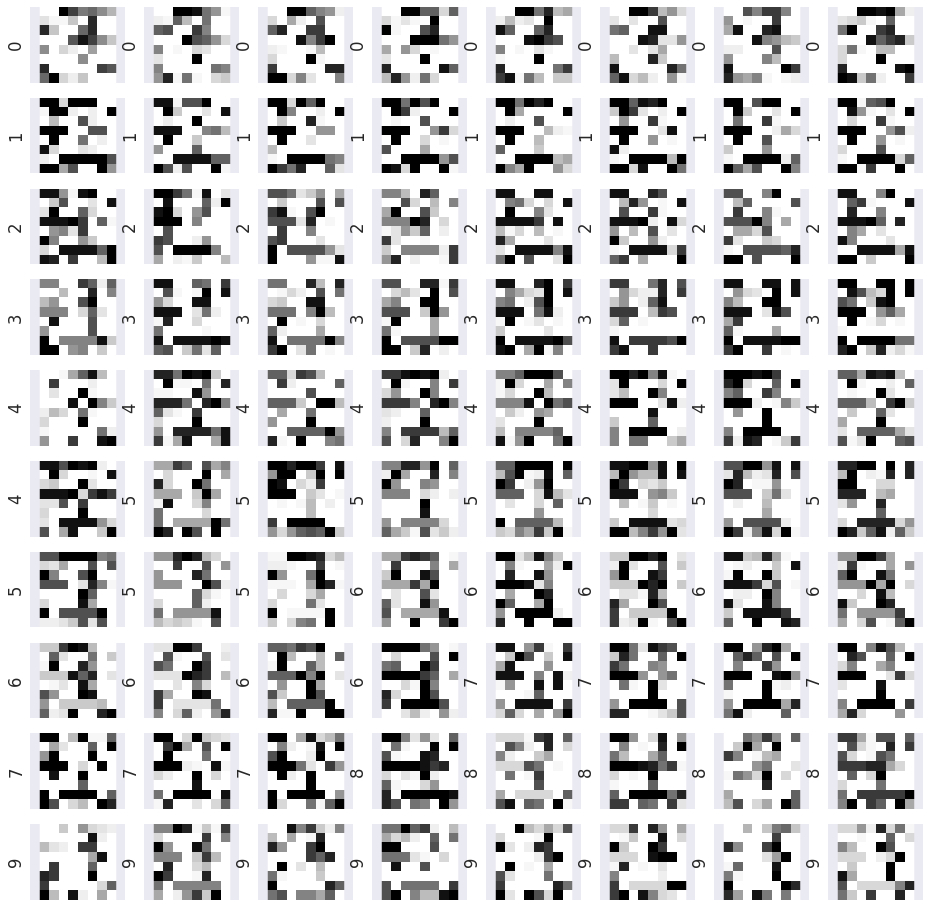

In [54]:
# Make sure columns in df_X_scrambled is indeed scrambled
n_per_digit = 8
nrows, ncols = 10, n_per_digit
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(16, 16))
axes = axes.ravel()
for i in range(10):
    for j in range(n_per_digit):
        ax = axes[i * n_per_digit + j]
        ax.matshow(df_all.iloc[j + 180 * i].values[descrambled_idxes.ravel()[:64].reshape(8, 8)])
        ax.set_ylabel('{0}'.format(y[j + 180 * i]))
        ax.grid(False)
        plt.xticks([])
        plt.yticks([])

This is a pattern for each digit, but far from as obvious as the original.

In [92]:
descrambled_idxes

array([[32, 15, 17, 26, 50,  3,  9, 21],
       [11, 52, 46, 48, 60, 57, 61, 63],
       [31, 20, 13, 35,  0, 55, 55,  7],
       [12, 23, 10,  8,  2, 47, 16, 30],
       [59, 24, 44, 58, 14, 42, 28,  4],
       [51, 37, 34, 41, 41,  0, 13, 45],
       [62, 53, 25, 56, 43, 29, 54,  1],
       [19, 40, 27,  6, 18, 22, 33, 49]])

In [94]:
vals = df.iloc[0].values[descrambled_idxes]

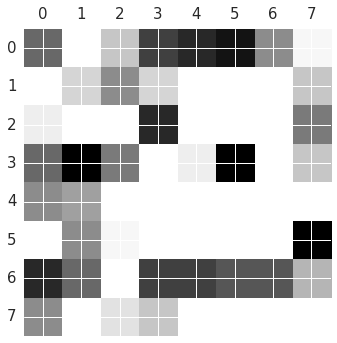

In [95]:
plt.matshow(vals)

In [87]:
descrambled_idxes.max()

63.0

In [88]:
vals[descrambled_idxes.astype(int)]

array([[ 10.,   0.,   5.,  12.,  13.,  14.,   8.,   1.],
       [  0.,   4.,   8.,   4.,   0.,   0.,   0.,   5.],
       [  2.,   0.,   0.,  13.,   0.,   0.,   0.,   9.],
       [ 10.,  15.,   9.,   0.,   2.,  15.,   0.,   5.],
       [  8.,   7.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   8.,   1.,   0.,   0.,   0.,   0.,  15.],
       [ 13.,  10.,   0.,  12.,  12.,  11.,  11.,   6.],
       [  8.,   0.,   3.,   5.,   0.,   0.,   0.,   0.]])

In [73]:
a = np.array([1, 2, 3, 4])

In [74]:
a

array([1, 2, 3, 4])

In [75]:
a[np.array([[0, 1], [2, 2]])]

array([[1, 2],
       [3, 3]])

In [54]:
%pdb

Automatic pdb calling has been turned OFF


In [289]:
np.pad(img, pad_width=[(0, 1), (0, 0)], mode='constant', constant_values=-1)

array([[ -1.,  43.,  -1.],
       [ 15.,   0.,  19.],
       [ -1.,  62.,  -1.],
       [ -1.,  -1.,  -1.]])

In [39]:
digits_proj = TSNE(random_state=RS, verbose=2).fit_transform(df_X_scrambled.values)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.121142
[t-SNE] Iteration 25: error = 1.7601628, gradient norm = 0.0074960
[t-SNE] Iteration 50: error = 1.5779889, gradient norm = 0.0065058
[t-SNE] Iteration 75: error = 1.1458678, gradient norm = 0.0042113
[t-SNE] Iteration 100: error = 1.0841460, gradient norm = 0.0042964
[t-SNE] Error after 100 iterations with early exaggeration: 1.084146
[t-SNE] Iteration 125: error = 0.9861298, gradient norm = 0.0041633
[t-SNE] Iteration 150: error = 0.9696192, gradient norm = 0.0037047
[t-SNE] Iteration 175: error = 0.9616197, gradient norm = 0.0039074
[t-SNE] Iteration 200: error = 0.9655997, gradient norm = 0.0043739
[t-SNE] Iteration 225: error = 0.9687797, gradient norm = 0.0047719
[t-SNE] Iteration 225: did not make any progress during the last 30 episodes. F

(<matplotlib.figure.Figure at 0x7f9804685690>,
  <matplotlib.text.Text at 0x7f9802685b10>])

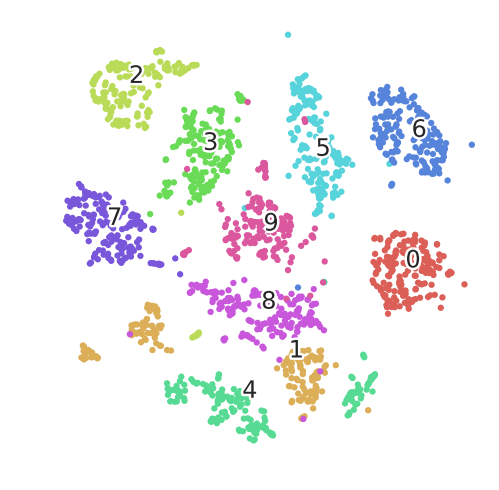

In [40]:
scatter(digits_proj, y)

You can see that even after being scrambled, the dataset can still be clustered in exactly the same way (with the same random seed) by t-SNE